# Setup

In [1]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import pymc3 as pm
import theano
import theano.tensor as tt
from sklearn.svm import LinearSVC
from sklearn.model_selection import PredefinedSplit, KFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

In [2]:
# change default plotting
plt.rcParams.update({'font.size': 22, 'figure.figsize': (10,4)})

In [102]:
# convenience functions

k2sd = lambda k : np.sqrt( -2 * np.log( sp.special.iv(1,k) / sp.special.iv(0,k) ) )

def sd2k(S):
    try:
        len(S)
    except:
        S = np.array([S])
    R = np.exp(-S**2/2)
    K = 1/(R**3 - 4 * R**2 + 3 * R)
    if np.any(R < 0.85):
        K[R < 0.85] = -0.4 + 1.39 * R[R < 0.85] + 0.43/(1 - R[R < 0.85])
    if np.any(R < 0.53):
        K[R < 0.53] = 2 * R[R < 0.53] + R[R < 0.53]**3 + (5 * R[R < 0.53]**5)/6
    if len(S) == 1:
        K = float(K)
    return K

def wrap360(a,b):
    try:
        len(a)
    except:
        a = np.array([a]); b= np.array([b])
    diff = np.full(len(a),np.nan)
    for k in np.arange(len(a)):
        diff[k] = b[k] - a[k]
        if diff[k] < -180:
            diff[k] = b[k] - a[k] + 360
        elif diff[k] > 180:
            diff[k] = b[k] - a[k] - 360
    return diff

def within360(x):
    try:
        len(x)
    except:
        x = np.array([x])
    x[x>359] = x[x>359]-360
    x[x<0] = x[x<0]+360
    return x

def within180(x):
    try:
        len(x)
    except:
        x = np.array([x])
    x[x<0] = x[x<0]+360
    x[x>180] = x[x>180]-360
    return np.abs(x)

# cosd is a helper function that allows us to work with degrees (0-359) instead of radians
cosd = lambda x : np.cos( np.deg2rad(x/2) )

make_cos_basis_sd = lambda xx, mu, sd : np.exp( sd2k(np.deg2rad(sd*2)) * cosd((xx*2-360)-mu*2) ) ** ( nchannels - (nchannels % 2) )
make_cos_basis = lambda xx, mu : cosd(xx-mu) ** ( nchannels - (nchannels % 2) )

# make_vox: create voxel tuning function, following a von Mises distribution
make_vox = lambda xx, mu, sd, amp : (np.exp( sd2k(np.deg2rad(sd*2)) * (cosd((xx*2-360)-mu*2)) )) ** (nchannels - (nchannels % 2)) * amp

def sim_vox():
    # Simulate neurons/voxels
    trial_features = list(map(int,np.random.choice(feature_space, ntrials)))
    trial_conds = np.tile(np.array([0,1]),ntrials//2)
    trial_by_vox = np.full([ntrials,nvoxels], np.nan)
    for vox in np.arange(nvoxels):
        vox_tuning = make_vox( 
            np.reshape(np.repeat(np.linspace(0,359,360),nneurons),[360,nneurons]),
            vox_by_neuron_mu[(vox*nneurons):((vox+1)*nneurons)],
            vox_by_neuron_sd[(vox*nneurons):((vox+1)*nneurons)],
            vox_by_neuron_amp[(vox*nneurons):((vox+1)*nneurons)])
        for trial in np.arange(ntrials):
            neuron_w_noise = vox_tuning[trial_features[trial],:] + (np.random.randn(nneurons)*neuron_noise)
            neuron_w_noise_and_gain = neuron_w_noise * (trial_conds[trial]*vox_gain_diff + 1)
            trial_by_vox[trial,vox] = np.sum(neuron_w_noise_and_gain)
    trial_by_vox = trial_by_vox.clip(min=0)
    return trial_by_vox, np.array(trial_features), trial_conds


# Simulate neurons and voxels

Here's the game plan. Within our fake ROI of 50 voxels (each voxel will contain 100 neurons), we will have 6 runs of 42 trials each. Trial condition will alternate every trial, for a total of 252 trials with 126 trials per condition. In one condition, neuron spiking will be of greater amplitude. 

In [755]:
# Simulation parameters:
ntrials = 300
nvoxels = 100
nneurons = 100
vox_sd_mu = .01
vox_sd_sd = .01
vox_gain_diff = 0
neuron_noise = 0

# IEM parameters:
nchannels = 6
chan_pow = np.ones(nchannels)
channel_sd = np.ones(nchannels)*5

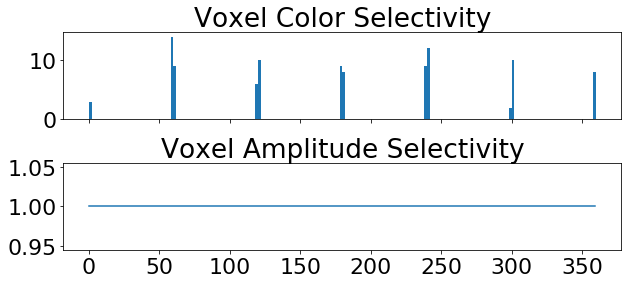

number of voxels: 100
number of neurons in every voxel: 100


In [756]:
vox_mu_basis = np.linspace(0,360-(360//nchannels),nchannels)
# basis_points = np.linspace(0,360 - 360/nchannels,nchannels)
basis_points = np.linspace(0,360-(360//nchannels),nchannels)+30

for chan in np.arange(len(basis_points)):
    basis_points[chan] = basis_points[chan]
basis_points = list(map(int, basis_points))

feature_space = np.linspace(0,359,360)

trial_features = list(map(int,np.random.choice(feature_space, ntrials)))

trial_conds = np.tile(np.array([0,1]),ntrials//2)

vox_amp = np.ones(360)

# vox_by_neuron_mu = np.random.rand(nvoxels,nneurons) * 360
y_mu = pm.NormalMixture.dist(w=np.ones(nchannels)/nchannels, 
                          mu=vox_mu_basis,
                          sigma=np.ones(nchannels)*vox_sd_sd)
vox_mu = within360(y_mu.random(size=nvoxels))

vox_by_neuron_mu = np.full( (nvoxels*nneurons), np.nan)
vox_by_neuron_amp = np.full( (nvoxels*nneurons), np.nan)
for vox in np.arange(nvoxels):
    n_mu = pm.Normal.dist(mu=vox_mu[vox],
                          sigma=vox_sd_sd)
    vox_by_neuron_mu[(vox*nneurons):((vox+1)*nneurons)] = within360(n_mu.random(size=nneurons))
    vox_by_neuron_amp[(vox*nneurons):((vox+1)*nneurons)] = vox_amp[int(vox_mu[vox])]
    
y_sd = pm.TruncatedNormal.dist(mu=vox_sd_mu, sd=vox_sd_sd, lower=0)
vox_by_neuron_sd = y_sd.random(size=(nvoxels*nneurons))

trial_by_vox = np.full([ntrials,nvoxels], np.nan)
    
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)    
fig.subplots_adjust(hspace=.5)
                
ax1.title.set_text('Voxel Color Selectivity')
ax1.hist(vox_mu, bins = 180)
    
ax2.plot(vox_amp)
ax2.title.set_text('Voxel Amplitude Selectivity')
plt.show()

print("number of voxels: {}".format(nvoxels))
print("number of neurons in every voxel: {}".format(nneurons))

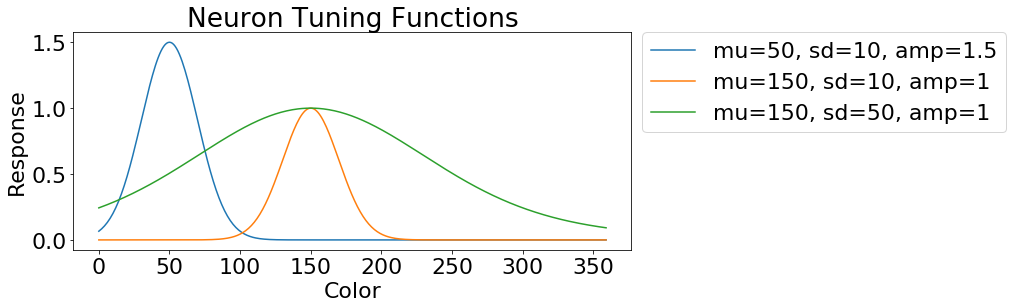

In [670]:
# demo of make_vox: 3 example neurons with different tuning functions
plt.plot(make_vox(np.linspace(0,359,360),50,10,1.5),label="mu=50, sd=10, amp=1.5")
plt.plot(make_vox(np.linspace(0,359,360),150,10,1),label="mu=150, sd=10, amp=1")
plt.plot(make_vox(np.linspace(0,359,360),150,50,1),label="mu=150, sd=50, amp=1")
plt.xlabel('Color')
plt.ylabel('Response')
plt.legend(bbox_to_anchor=(1, 1.05))
plt.title("Neuron Tuning Functions")
plt.show()

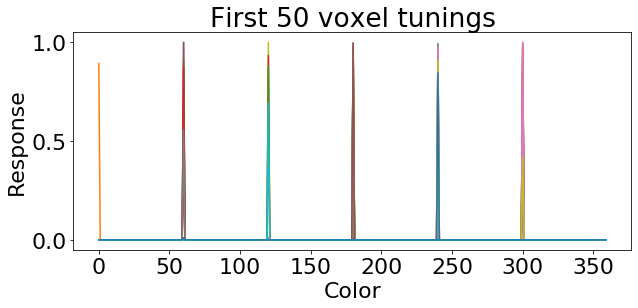

In [671]:
for vox in np.arange(nvoxels):
    # for every voxel, we simulate 100 neurons...
    vox_tuning = make_vox( 
        np.reshape(np.repeat(np.linspace(0,359,360),nneurons),[360,nneurons]),
        vox_by_neuron_mu[(vox*nneurons):((vox+1)*nneurons)],
        vox_by_neuron_sd[(vox*nneurons):((vox+1)*nneurons)],
        vox_by_neuron_amp[(vox*nneurons):((vox+1)*nneurons)])
    if vox <= 50:
        plt.plot(np.linspace(0,359,360),vox_tuning[:,vox])
        plt.xlabel('Color')
        plt.ylabel('Response')
        plt.title('First 50 voxel tunings')
    # we then add random noise, possible condition-specific amplitude changes, 
    # and then sum across how each neuron responds to each trial's feature for each voxel
    for trial in np.arange(ntrials):
        neuron_w_noise = vox_tuning[trial_features[trial],:] + (np.random.randn(nneurons)*neuron_noise)
        neuron_w_noise_and_gain = neuron_w_noise * (trial_conds[trial]*vox_gain_diff + 1)
        trial_by_vox[trial,vox] = np.sum(neuron_w_noise_and_gain)
trial_by_vox = trial_by_vox.clip(min=0)

# Inverted Encoding Model

## Create Forward Model & Design Matrix

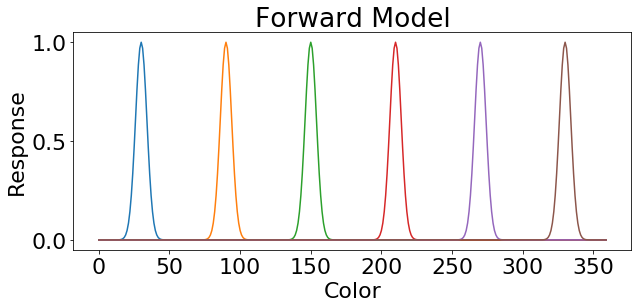

In [672]:
basis_set = np.full( (360 , nchannels) , np.nan)
    
# create each basis channel
for chan in np.arange(nchannels):
    basis_set[:,chan] = make_cos_basis_sd( feature_space*2-360, (basis_points[chan]-180)*2, channel_sd[chan]*2 )
    
# normalize channels
scaler = MinMaxScaler()
for chan in np.arange(nchannels):
    scaler.fit(basis_set[:,chan].reshape(-1, 1))
    basis_set[:,chan] = scaler.transform(basis_set[:,chan].reshape(-1, 1)).flatten()
        
# plot basis functions
for chan in np.arange(nchannels):
    plt.plot(basis_set[:,chan])

plt.xlabel('Color')
plt.ylabel('Response')
plt.title("Forward Model")
plt.show()


In [359]:
# # show how forward model changes with different bandwidths:
# with plt.rc_context({'font.size': 10, 'figure.figsize': (5,2)}):
#     for bd in np.linspace(0,90,5):
#         print(bd)
#         for chan in np.arange(nchannels):
#             if bd == 0: # make_cos_basis_sd fails if bd < 10; need exception for stick function
#                 basis_set[:,chan] = np.zeros(360)
#                 basis_set[int(basis_points[chan]),chan] = 1
#             else: 
#                 basis_set[:,chan] = make_cos_basis_sd( feature_space, basis_points[chan], bd )
#             plt.plot(basis_set[:,chan])
#         plt.show()

In [360]:
# Original code created stimulus mask and then calculated trial weights like so, which I think is overly complicated and 
# can be boiled down into a single line of code in the cell below ...

# stim_mask = np.zeros( (ntrials,nchannels) )
# for trial in np.arange(ntrials):
#     stim_mask[trial,int(trial_features[trial]/(360/nchannels))]=1
    
# # stim_mask: what basis function corresponds to the ground truth for every trial?

# trial_weights = basis_set[basis_points,:] @ stim_mask.T

# # trial_weights: what activation of each basis function look like for every trial based on stim_mask?

# fig, (ax1, ax2) = plt.subplots(1, 2)

# ax1.imshow(stim_mask[:18,:])
# ax1.set(xlabel='Channel', ylabel='Trial ...');

# for trial in np.arange(ntrials):
#     ax2.plot(trial_weights[:,trial])

# ax2.set(xlabel='Channel', ylabel='Weight');

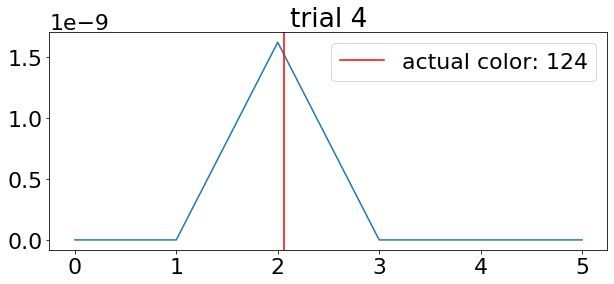

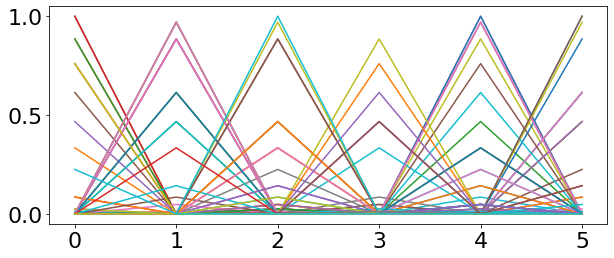

In [361]:
trial_weights = basis_set[trial_features,:]

trial = 3
plt.plot(trial_weights[trial,:])
plt.title("trial {}".format(trial+1))
plt.axvline(trial_features[trial]/360 * nchannels,color='red',label="actual color: {}".format(trial_features[trial]))
plt.legend()
plt.show()

for trial in np.arange(ntrials):
    plt.plot(trial_weights[trial,:])
plt.show()

trn = trial_by_vox[:ntrials//2,:] # training: trial "Betas"
trnf = np.array(trial_features[:ntrials//2]) # training trial features
tst = trial_by_vox[ntrials//2:,:] # testing: trial "Betas"
tstf = np.array(trial_features[ntrials//2:]) # test trial features

trn_or_tst = np.hstack((np.full( len(trn) , 0), np.full( len(tst) , 1)))

## Test if channels are linearly dependent
Test to see if we have a full rank design matrix (tests if channels are linearly dependent). Linearly dependent channels are bad because it means that at least one of the channels can be defined as a linear combination of the others. This is bad because then we can't uniquely estimate the contribution of each channel to the signal observed in a given voxel. In other words, if trail_weights is not full rank then we have effectively lost the contribution of at least one of the nchannel dimensions.

In [362]:
print('Design matrix: rank = {}'.format( np.linalg.matrix_rank(trial_weights) ))
if np.linalg.matrix_rank(trial_weights) != nchannels:
    raise Exception('trial_weights not full rank')

Design matrix: rank = 6


## Compute weights of forward model

In [363]:
channelweights_per_vox = np.linalg.lstsq(trial_weights[trn_or_tst==0,:] , trn, rcond=None)[0] 
# solution of trial_weights @ w = trn; this is an exact solution if trial_weights is full rank

In [364]:
# # visualization of results so far...
# with plt.rc_context({'font.size': 13}):
#     fig, (ax1, ax2, ax3) = plt.subplots(3, 1);
#     plt.subplots_adjust(hspace = 1.6)
    
#     vox_idx = int(np.where(channelweights_per_vox[0,:] == np.min(channelweights_per_vox[0,:]))[0])

#     ax1.plot(channelweights_per_vox[1:,:].T,linewidth=.5);
#     ax1.plot(channelweights_per_vox[0,:],linewidth=4,color='black');
#     ax1.axvline(x=vox_idx,linewidth=2,color='red');
#     ax1.set(title='Channel 1: Weight across voxels');

#     ax2.plot(np.mean(trn[trnf==0,:],axis=0),'o',label='Trials where stim was center of channel 1');
#     ax2.plot(np.mean(trn[trnf!=0,:],axis=0),'o',label='Trials where stim wasn''t center of channel 1');
#     ax2.axvline(x=vox_idx,linewidth=2,color='red');
#     ax2.legend(bbox_to_anchor=(1, 1.05))
#     ax2.set(title='Mean voxel activation (training trial)');
    
#     ax3.plot(np.mean(tst[tstf==0,:],axis=0),'o');
#     ax3.plot(np.mean(tst[tstf!=0,:],axis=0),'o');
#     ax3.axvline(x=vox_idx,linewidth=2,color='red');
#     ax3.set(title='Mean voxel activation (test trials)',xlabel='Voxel #');

## Invert to compute channel responses

### Reconstruct training data (note: this is circular, it should be near-perfect!)

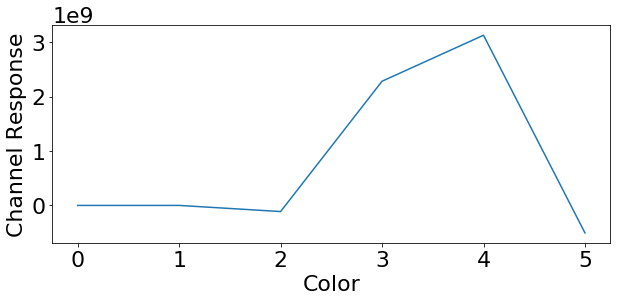

In [365]:
cr_trn = np.linalg.lstsq(channelweights_per_vox.T , trn.T, rcond=None)[0].T

cr_center_trn = np.empty_like(cr_trn)
shiftby = nchannels//2
for trial in np.arange(cr_trn.shape[0]):
    closest_basis = np.argmin(np.abs( np.array(trnf[trial]) - basis_points ))
    cr_center_trn[trial,:] = np.roll( cr_trn[trial,:], shiftby - closest_basis );
    
plt.plot(np.mean(cr_center_trn,axis=0))
plt.xlabel("Color")
plt.ylabel("Channel Response")
plt.show()

### Assess training reconstruction fit

MAE: 63.92666666666667


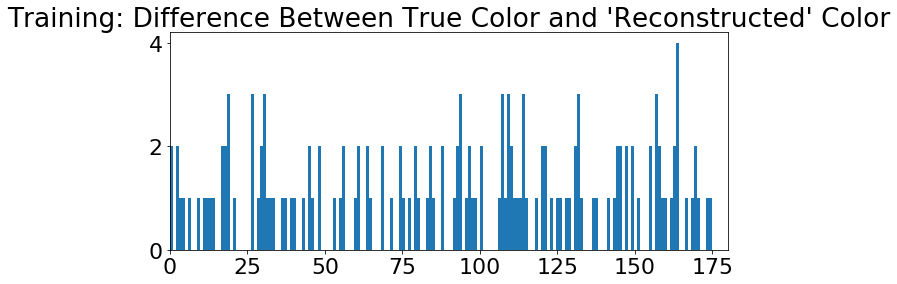

In [366]:
# Reconstruct the stimulus:
estimated_color = np.full(cr_trn.shape[0],np.nan)

for trial in np.arange(cr_trn.shape[0]):
    estimated_color[trial] = basis_points[np.argmax(cr_trn[trial,:])]
    
plt.hist(within180(estimated_color - trnf), bins=180, label="")
plt.xlim(xmin=0, xmax = 180)
plt.title("Training: Difference Between True Color and 'Reconstructed' Color")

trn_mae = mean_absolute_error(within180(trnf), within180(estimated_color))
print("MAE: {}".format(trn_mae))

### Reconstruct test data

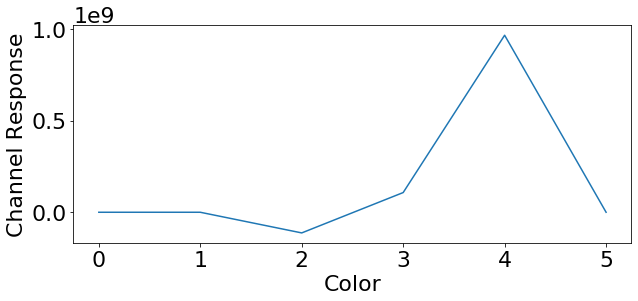

In [367]:
cr_tst = np.linalg.lstsq(channelweights_per_vox.T , tst.T, rcond=None)[0].T

cr_center_tst = np.empty_like(cr_tst)
shiftby = nchannels//2
for ii in np.arange(cr_tst.shape[0]):
    closest_basis = np.argmin(np.abs( tstf[ii] - basis_points ))
    cr_center_tst[ii,:] = np.roll( cr_tst[ii,:], shiftby - closest_basis );
    
plt.plot(np.mean(cr_center_tst,axis=0))
plt.xlabel("Color")
plt.ylabel("Channel Response")
plt.xticks(np.arange(nchannels))
plt.show()

### Assess test reconstruction fit

MAE: 65.76


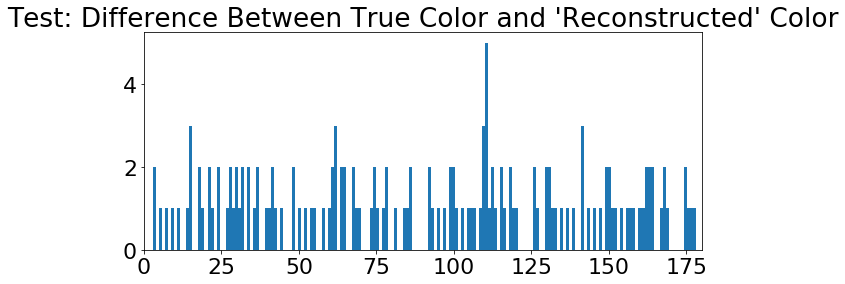

In [368]:
# Reconstruct the stimulus:
estimated_color = np.full(cr_tst.shape[0],np.nan)

for trial in np.arange(cr_tst.shape[0]):
    estimated_color[trial] = basis_points[np.argmax(cr_tst[trial,:])]
    
plt.hist(within180(estimated_color - tstf), bins=180, label="")
plt.xlim(xmin=0, xmax = 180)
plt.title("Test: Difference Between True Color and 'Reconstructed' Color")

tst_mae = mean_absolute_error(within180(tstf), within180(estimated_color))
print("MAE: {}".format(tst_mae))

### Null Distribution / Significance Test

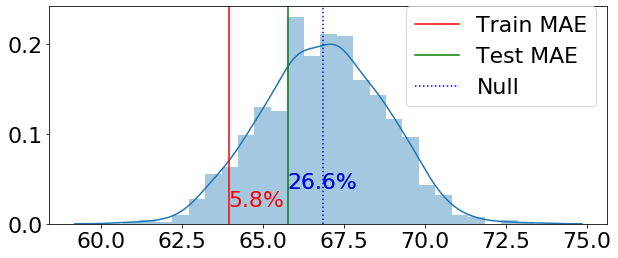

Model performance: 1.097079999999995


In [369]:
# Reconstruct the stimulus:
estimated_color = np.full(cr_tst.shape[0],np.nan)
null_mae = np.full(1000,np.nan)

def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

for perm in np.arange(1000):
    shuffled_tst, shuffled_tstf = unison_shuffled_copies(tst,tstf)
    cr_shuffle_tst = np.linalg.lstsq(channelweights_per_vox.T , shuffled_tst.T, rcond=None)[0].T
    for trial in np.arange(cr_shuffle_tst.shape[0]):
        estimated_color[trial] = basis_points[np.argmax(cr_tst[trial,:])]

    null_mae[perm] = mean_absolute_error(within180(shuffled_tstf), within180(estimated_color))

trn_overlap = len(null_mae[null_mae<trn_mae])/len(null_mae) * 100
tst_overlap = len(null_mae[null_mae<tst_mae])/len(null_mae) * 100

sns.distplot(null_mae)
plt.axvline(trn_mae,color='red',label="Train MAE")
plt.axvline(tst_mae,color='green',label="Test MAE")
plt.axvline(np.mean(null_mae),linestyle=':',color='blue',label="Null")
plt.legend(bbox_to_anchor=(1, 1.05))
plt.text(trn_mae,.02,"{:.1f}%".format(trn_overlap),color='red')
plt.text(tst_mae,.04,"{:.1f}%".format(tst_overlap),color='green')
plt.text(tst_mae,.04,"{:.1f}%".format(tst_overlap),color='blue')
plt.show()

print("Model performance: {}".format(np.mean(null_mae - tst_mae)))

## Compare reconstructions across conditions

In [372]:
# plt.plot(np.mean(cr_center_tst[trial_conds[trials_to_include][trn_or_tst==1]==0],axis=0),color='red',label="Condition 1")
# plt.plot(np.mean(cr_center_tst[trial_conds[trials_to_include][trn_or_tst==1]==1],axis=0),color='blue',label="Condition 1")
# plt.xlabel("Color")
# plt.ylabel("Channel Response")
# plt.legend(bbox_to_anchor=(1, 1.05))
# plt.show()

# Function to automate IEM

In [335]:
# def auto_recon(basis_points,trial_features,trial_by_vox,channel_sd,chan_pow):  
#     # creating helper function to create null distribution later on:
#     def unison_shuffled_copies(a, b):
#         assert len(a) == len(b)
#         p = np.random.permutation(len(a))
#         return a[p], b[p]
        
#     # create each basis channel
#     basis_set = np.full( (360 , nchannels) , np.nan)
#     for chan in np.arange(nchannels):
#         basis_set[:,chan] = make_cos_basis_sd( feature_space*2-360, (basis_points[chan]-180)*2, channel_sd[chan]*2 )

#     # normalize channels
#     scaler = MinMaxScaler()
#     for chan in np.arange(nchannels):
#         scaler.fit(basis_set[:,chan].reshape(-1, 1))
#         basis_set[:,chan] = scaler.transform(basis_set[:,chan].reshape(-1, 1)).flatten() * chan_pow[chan]

#     # plot basis_set
#     if sims == 0:
#         for chan in np.arange(nchannels):
#             plt.plot(basis_set[:,chan])
#         plt.title('Basis Set for Condition {}'.format(cond))
#         plt.show()

#     trial_weights = basis_set[trial_features,:]

#     # exclude trials not covered by basis set
# #     for trial in np.arange(ntrials):
# #         if (np.sum(trial_weights[trial,:]) < .1):
# #             trial_weights[trial,:] = np.nan
# #     trials_to_include = ~np.isnan(trial_weights).any(axis=1)
    
#     # if we wanted to not do any trial exclusion:
#     trials_to_include = (np.ones(ntrials) == 1)

#     trial_weights = trial_weights[trials_to_include,:]
#     trial_by_vox = trial_by_vox[trials_to_include,:]
#     trial_features = np.array(trial_features)[trials_to_include]

#     ## Cross-validation ##
#     n_splits = 2
#     kf = KFold(n_splits=n_splits, shuffle=False) 
#     X = np.linspace(0,np.sum(trials_to_include)-1,np.sum(trials_to_include)) 
#     kf.get_n_splits(X)

#     tst_mae = np.full(n_splits,np.nan)
#     perf = np.full(n_splits,np.nan)
#     cv_iter = -1

#     for train_index, test_index in kf.split(X):
#         cv_iter = cv_iter+1

#         trn = trial_by_vox[train_index,:]
#         tst = trial_by_vox[test_index,:]

#         tstf = trial_features[test_index]
#         trn_or_tst = np.zeros(len(trial_features))
#         trn_or_tst[test_index] = 1

#         # ensure that trial_weights is full rank
#         if np.linalg.matrix_rank(trial_weights) != nchannels:
#             raise Exception('sim: {}, rank: {}, trial_weights is not full rank'.format(sims,np.linalg.matrix_rank(trial_weights)))

#         channelweights_per_vox = np.linalg.lstsq(trial_weights[trn_or_tst==0,:], trn, rcond=None)[0] 
#         # solution of trial_weights @ w = trn; this is an exact solution if trial_weights is full rank

#         cr_tst = np.linalg.lstsq(channelweights_per_vox.T , tst.T, rcond=None)[0].T

#         estimated_color = np.full(cr_tst.shape[0],np.nan)
#         for trial in np.arange(cr_tst.shape[0]):
#             estimated_color[trial] = basis_points[np.argmax(cr_tst[trial,:])]

#         tst_mae[cv_iter] = mean_absolute_error(within180(tstf), within180(estimated_color))
        
#         # Null distribution:
#         estimated_color = np.full(cr_tst.shape[0],np.nan)
#         null_mae = np.full(100,np.nan)

#         for perm in np.arange(100):
#             shuffled_tst, shuffled_tstf = unison_shuffled_copies(tst,tstf)
#             cr_shuffle_tst = np.linalg.lstsq(channelweights_per_vox.T , shuffled_tst.T, rcond=None)[0].T
#             for trial in np.arange(cr_shuffle_tst.shape[0]):
#                 estimated_color[trial] = basis_points[np.argmax(cr_tst[trial,:])]

#             null_mae[perm] = mean_absolute_error(within180(shuffled_tstf), within180(estimated_color))

#         perf[cv_iter] = 1 / np.mean(null_mae - tst_mae[cv_iter])
# #         perf[cv_iter] = np.sum(null_mae[0:len(tst)] - tst_mae[cv_iter])
    
#     return perf

In [148]:
def auto_recon(basis_points,channel_sd,chan_pow,trial_features,trial_by_vox):  
    # create each basis channel
    basis_set = np.full( (360 , nchannels) , np.nan)
    for chan in np.arange(nchannels):
        basis_set[:,chan] = make_cos_basis_sd( feature_space, (basis_points[chan]-180), channel_sd[chan] )

    # normalize channels
    scaler = MinMaxScaler()
    for chan in np.arange(nchannels):
        scaler.fit(basis_set[:,chan].reshape(-1, 1))
        basis_set[:,chan] = scaler.transform(basis_set[:,chan].reshape(-1, 1)).flatten() * chan_pow[chan]

    # plot basis_set
    if sims == 0:
        for chan in np.arange(nchannels):
            plt.plot(basis_set[:,chan])
        plt.title('Basis Set')
        plt.show()

    trial_weights = basis_set[trial_features,:]

    ## Cross-validation ##
    tst_mae = np.full(n_splits,np.nan)
#     tst_mae = np.full( (n_splits,len(trial_features)//n_splits), np.nan)
    cv_iter = -1
    for train_index, test_index in kf.split(X):
        cv_iter = cv_iter+1

        trn = trial_by_vox[train_index,:]
        tst = trial_by_vox[test_index,:]

        tstf = trial_features[test_index]
        trn_or_tst = np.zeros(len(trial_features))
        trn_or_tst[test_index] = 1

        # ensure that trial_weights is full rank
        if np.linalg.matrix_rank(trial_weights) != nchannels:
            raise Exception('sim: {}, rank: {}, trial_weights is not full rank'.format(sims,np.linalg.matrix_rank(trial_weights)))
            
        channelweights_per_vox = np.linalg.lstsq(trial_weights[trn_or_tst==0,:], trn, rcond=None)[0] 
        # solution of trial_weights @ w = trn; this is an exact solution if trial_weights is full rank

        cr_tst = np.linalg.lstsq(channelweights_per_vox.T , tst.T, rcond=None)[0].T

        estimated_color = np.full(cr_tst.shape[0],np.nan)
        for trial in np.arange(cr_tst.shape[0]):
            estimated_color[trial] = basis_points[np.argmax(cr_tst[trial,:])]

        tst_mae[cv_iter] = np.mean(np.abs(wrap360(tstf,estimated_color))) # mean absolute error
    
    return tst_mae

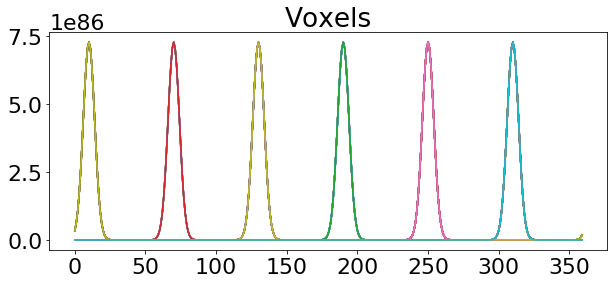

[ 10.  70. 130. 190. 250. 310.]
[ 10.  70. 130. 190. 250. 310.]


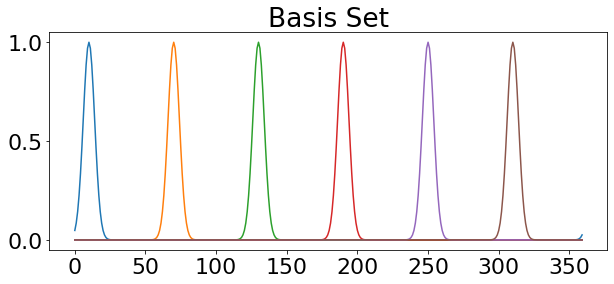

15.06
[ 26.68965771  83.89704337 143.30056459 206.24114361 264.23158766
 315.06661039]
19.41438203728539


In [133]:
ntrials = 100
nvoxels = 100
nneurons = 100
nchannels = 6
vox_gain_diff = 0
neuron_noise = 0
feature_space = np.linspace(0,359,360)

true_sh = 10
true_sh_sd = .01
true_sd = 5
true_amp = 1

# Voxel (mu)
vox_mu_basis = np.linspace(0,360-(360//nchannels),nchannels)+true_sh
y_mu = pm.NormalMixture.dist(w=np.ones(nchannels)/nchannels, 
                          mu=vox_mu_basis,
                          sigma=np.ones(nchannels)*true_sh_sd)
vox_mu = within360(y_mu.random(size=nvoxels))

# Voxel (sd)
vox_sd_sd = .01
y_sd = pm.TruncatedNormal.dist(mu=true_sd, sd=vox_sd_sd, lower=0)
vox_by_neuron_sd = y_sd.random(size=(nvoxels*nneurons))

# Voxel (amp)
vox_amp = np.ones(360)

# Simulate voxels:
vox_by_neuron_mu = np.full( (nvoxels*nneurons), np.nan)
vox_by_neuron_amp = np.full( (nvoxels*nneurons), np.nan)
for vox in np.arange(nvoxels):
    n_mu = pm.Normal.dist(mu=vox_mu[vox],
                          sigma=.01)
    vox_by_neuron_mu[(vox*nneurons):((vox+1)*nneurons)] = within360(n_mu.random(size=nneurons))
    vox_by_neuron_amp[(vox*nneurons):((vox+1)*nneurons)] = vox_amp[int(vox_mu[vox])]

# setup cross-validation
n_splits = 2
kf = KFold(n_splits=n_splits, shuffle=False) 
X = np.linspace(0,ntrials-1,np.sum(ntrials)) 
kf.get_n_splits(X)

# run sim_vox
trial_by_vox, trial_features, trial_conds = sim_vox()

# Plot simulated voxel tunings:               
plt.title('Voxels')
for vox in np.arange(nvoxels):
    plt.plot(make_vox(np.linspace(0,359,360),vox_mu[vox],true_sd,vox_amp[vox]))
    
plt.show()

###
sims=0
channel_sd = np.ones(nchannels)*true_sd
chan_pow = np.ones(nchannels)

print(vox_mu_basis)
basis_points = np.linspace(0,360-(360//nchannels),nchannels)+true_sh
print(basis_points)
print(np.mean(auto_recon(basis_points,channel_sd,chan_pow,trial_features,trial_by_vox)))

sims=1
basis_points = basis_points + [np.mean(trace['sh0']),np.mean(trace['sh1']),np.mean(trace['sh2']),np.mean(trace['sh3']),np.mean(trace['sh4']),np.mean(trace['sh5'])]
print(basis_points)
print(np.mean(auto_recon(basis_points,channel_sd,chan_pow,trial_features,trial_by_vox)))

(6, 6)
0.014051496143666893
0.07273488392065507


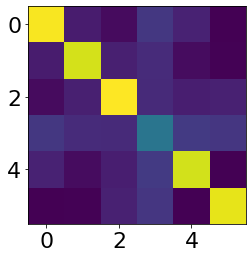

In [63]:
b=np.cov(cr_tst.T)
# good basis
print(b.shape)
plt.imshow(b)
print(np.mean(np.abs(b[np.where(~np.eye(b.shape[0],dtype=bool))])))
print(np.mean(np.abs(b[np.where(np.eye(b.shape[0],dtype=bool))])))

# Testing out some parameters

## On-basis v. off-basis

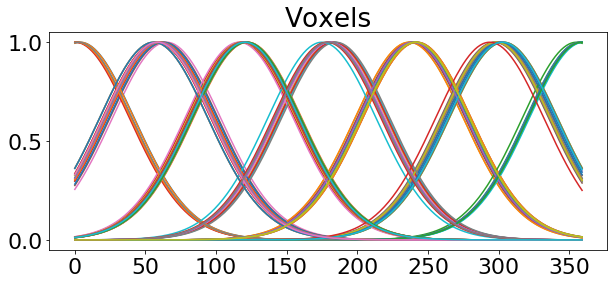

In [26]:
# Simulation parameters:
nsims = 30
ntrials = 100
nvoxels = 100
nneurons = 100
nchannels = 6
vox_gain_diff = 0
neuron_noise = 0
feature_space = np.linspace(0,359,360)

true_sh = 20
true_sh_sd = 2
true_sd = 20
true_amp = 1

# Voxel (mu)
vox_mu_basis = np.linspace(0,360-(360//nchannels),nchannels)+true_sh
y_mu = pm.NormalMixture.dist(w=np.ones(nchannels)/nchannels, 
                          mu=vox_mu_basis,
                          sigma=np.ones(nchannels)*true_sh_sd)
vox_mu = within360(y_mu.random(size=nvoxels))

# Voxel (sd)
vox_sd_sd = .01
y_sd = pm.TruncatedNormal.dist(mu=true_sd, sd=vox_sd_sd, lower=0)
vox_by_neuron_sd = y_sd.random(size=(nvoxels*nneurons))

# Voxel (amp)
vox_amp = np.ones(360)

# Simulate voxels:
vox_by_neuron_mu = np.full( (nvoxels*nneurons), np.nan)
vox_by_neuron_amp = np.full( (nvoxels*nneurons), np.nan)
for vox in np.arange(nvoxels):
    n_mu = pm.Normal.dist(mu=vox_mu[vox],
                          sigma=true_sd)
    vox_by_neuron_mu[(vox*nneurons):((vox+1)*nneurons)] = within360(n_mu.random(size=nneurons))
    vox_by_neuron_amp[(vox*nneurons):((vox+1)*nneurons)] = vox_amp[int(vox_mu[vox])]

# setup cross-validation
n_splits = 2
kf = KFold(n_splits=n_splits, shuffle=False) 
X = np.linspace(0,ntrials-1,np.sum(ntrials)) 
kf.get_n_splits(X)

# Plot simulated voxel tunings:               
plt.title('Voxels')
for vox in np.arange(nvoxels):
    plt.plot(make_vox(np.linspace(0,359,360),vox_mu[vox],true_sd,vox_amp[vox]))
    
plt.show()

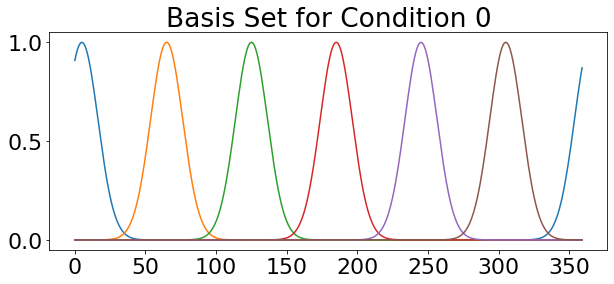

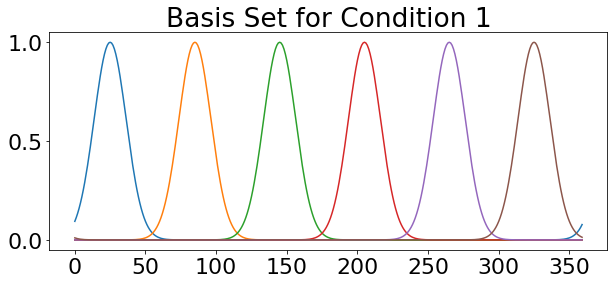

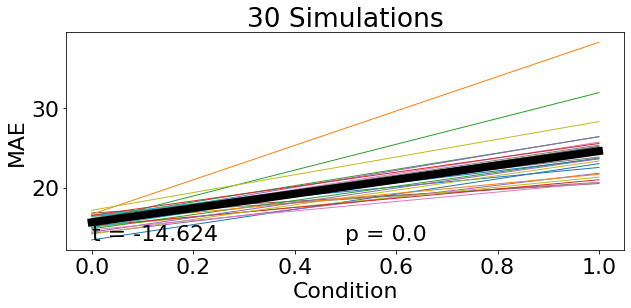

In [14]:
# compare possible basis sets
mae = np.full( (nsims, 2),np.nan )
for sims in np.arange(nsims):
    trial_by_vox, trial_features, trial_conds = sim_vox()
    for cond in np.arange(2):
        if cond == 0:
            basis_points = np.linspace(0,360-(360//nchannels),nchannels)+5
            channel_sd = np.ones(nchannels)*15
            chan_pow = np.ones(nchannels)
        else:
            basis_points = np.linspace(0,360-(360//nchannels),nchannels)+25
            channel_sd = np.ones(nchannels)*15
            chan_pow = np.ones(nchannels)
        mae[sims,cond] = np.mean(auto_recon(basis_points,channel_sd,chan_pow,trial_features,trial_by_vox))
    plt.plot(mae[sims,:], linewidth=1)
    
# correlation test
stats = sp.stats.ttest_rel(mae[:,0],mae[:,1])
tvalue = stats[0]
pvalue = stats[1]
    
plt.plot(np.mean(mae,axis=0), color='black', linewidth=8)
plt.title('30 Simulations')
plt.xlabel('Condition')
plt.ylabel('MAE')
plt.text(0,np.min(mae),"t = {}".format(np.round(tvalue,decimals=3)))
plt.text(0.5,np.min(mae),"p = {}".format(np.round(pvalue,decimals=4)))
plt.show()

## Small-SD on-basis v. medium-SD on-basis (for small sd voxels)

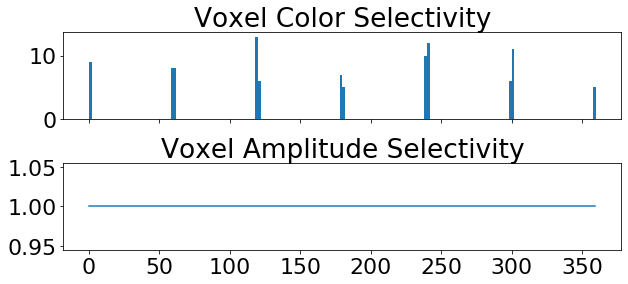

In [764]:
# Simulation parameters:
nsims = 30
ntrials = 300
nvoxels = 100
nneurons = 100
nchannels = 6
vox_gain_diff = 0
neuron_noise = 0
feature_space = np.linspace(0,359,360)

# Voxel (mu)
vox_mu_basis = np.linspace(0,360-(360//nchannels),nchannels)
vox_sd_mu = .01
vox_sd_sd = .01
y_mu = pm.NormalMixture.dist(w=np.ones(nchannels)/nchannels, 
                          mu=vox_mu_basis,
                          sigma=np.ones(nchannels)*vox_sd_sd)
vox_mu = within360(y_mu.random(size=nvoxels))

# Voxel (sd)
y_sd = pm.TruncatedNormal.dist(mu=vox_sd_mu, sd=vox_sd_sd, lower=0)
vox_by_neuron_sd = y_sd.random(size=(nvoxels*nneurons))

# Voxel (amp)
vox_amp = np.ones(360)

# Simulate voxels:
vox_by_neuron_mu = np.full( (nvoxels*nneurons), np.nan)
vox_by_neuron_amp = np.full( (nvoxels*nneurons), np.nan)
for vox in np.arange(nvoxels):
    n_mu = pm.Normal.dist(mu=vox_mu[vox],
                          sigma=vox_sd_sd)
    vox_by_neuron_mu[(vox*nneurons):((vox+1)*nneurons)] = within360(n_mu.random(size=nneurons))
    vox_by_neuron_amp[(vox*nneurons):((vox+1)*nneurons)] = vox_amp[int(vox_mu[vox])]

# setup cross-validation
n_splits = 2
kf = KFold(n_splits=n_splits, shuffle=False) 
X = np.linspace(0,ntrials-1,np.sum(ntrials)) 
kf.get_n_splits(X)

# Plot simulated voxel tunings:
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)    
fig.subplots_adjust(hspace=.5)
                
ax1.title.set_text('Voxel Color Selectivity')
ax1.hist(vox_mu, bins = 180)
    
ax2.plot(vox_amp)
ax2.title.set_text('Voxel Amplitude Selectivity')
plt.show()

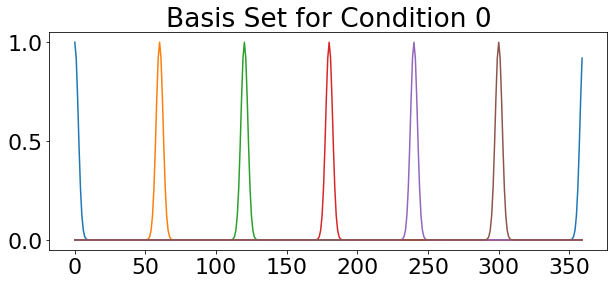

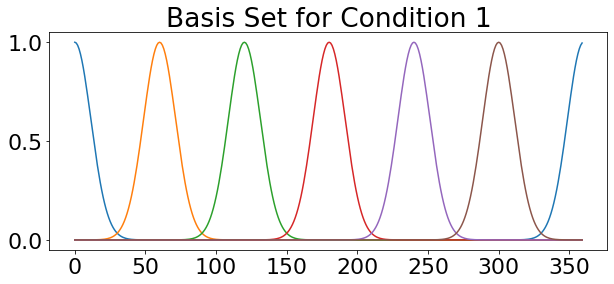

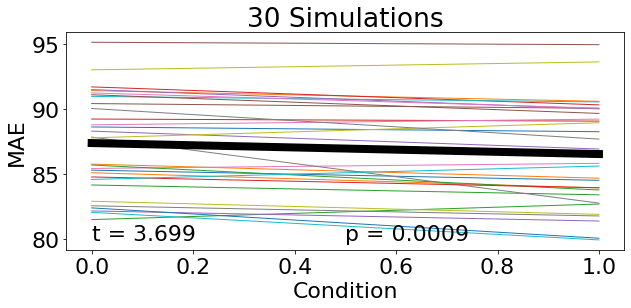

In [765]:
# compare possible basis sets
mae = np.full( (nsims, 2),np.nan )
for sims in np.arange(nsims):
    trial_by_vox, trial_features, trial_conds = sim_vox()
    for cond in np.arange(2):
        if cond == 0:
            basis_points = np.linspace(0,360-(360//nchannels),nchannels)
            channel_sd = np.ones(nchannels)*3
            chan_pow = np.ones(nchannels)
        else:
            basis_points = np.linspace(0,360-(360//nchannels),nchannels)
            channel_sd = np.ones(nchannels)*15
            chan_pow = np.ones(nchannels)
        mae[sims,cond] = np.mean(auto_recon(basis_points,trial_features,trial_by_vox,channel_sd,chan_pow))
    plt.plot(mae[sims,:], linewidth=1)
    
# correlation test
stats = sp.stats.ttest_rel(mae[:,0],mae[:,1])
tvalue = stats[0]
pvalue = stats[1]
    
plt.plot(np.mean(mae,axis=0), color='black', linewidth=8)
plt.title('30 Simulations')
plt.xlabel('Condition')
plt.ylabel('MAE')
plt.text(0,np.min(mae),"t = {}".format(np.round(tvalue,decimals=3)))
plt.text(0.5,np.min(mae),"p = {}".format(np.round(pvalue,decimals=4)))
plt.show()

## Small-SD off-basis v. medium-SD off-basis (for small sd voxels)

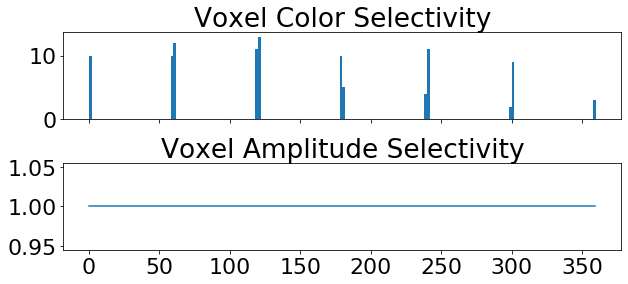

In [766]:
# Simulation parameters:
nsims = 30
ntrials = 300
nvoxels = 100
nneurons = 100
nchannels = 6
vox_gain_diff = 0
neuron_noise = 0
feature_space = np.linspace(0,359,360)

# Voxel (mu)
vox_mu_basis = np.linspace(0,360-(360//nchannels),nchannels)
vox_sd_mu = .01
vox_sd_sd = .01
y_mu = pm.NormalMixture.dist(w=np.ones(nchannels)/nchannels, 
                          mu=vox_mu_basis,
                          sigma=np.ones(nchannels)*vox_sd_sd)
vox_mu = within360(y_mu.random(size=nvoxels))

# Voxel (sd)
y_sd = pm.TruncatedNormal.dist(mu=vox_sd_mu, sd=vox_sd_sd, lower=0)
vox_by_neuron_sd = y_sd.random(size=(nvoxels*nneurons))

# Voxel (amp)
vox_amp = np.ones(360)

# Simulate voxels:
vox_by_neuron_mu = np.full( (nvoxels*nneurons), np.nan)
vox_by_neuron_amp = np.full( (nvoxels*nneurons), np.nan)
for vox in np.arange(nvoxels):
    n_mu = pm.Normal.dist(mu=vox_mu[vox],
                          sigma=vox_sd_sd)
    vox_by_neuron_mu[(vox*nneurons):((vox+1)*nneurons)] = within360(n_mu.random(size=nneurons))
    vox_by_neuron_amp[(vox*nneurons):((vox+1)*nneurons)] = vox_amp[int(vox_mu[vox])]

# setup cross-validation
n_splits = 2
kf = KFold(n_splits=n_splits, shuffle=False) 
X = np.linspace(0,ntrials-1,np.sum(ntrials)) 
kf.get_n_splits(X)

# Plot simulated voxel tunings:
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)    
fig.subplots_adjust(hspace=.5)
                
ax1.title.set_text('Voxel Color Selectivity')
ax1.hist(vox_mu, bins = 180)
    
ax2.plot(vox_amp)
ax2.title.set_text('Voxel Amplitude Selectivity')
plt.show()

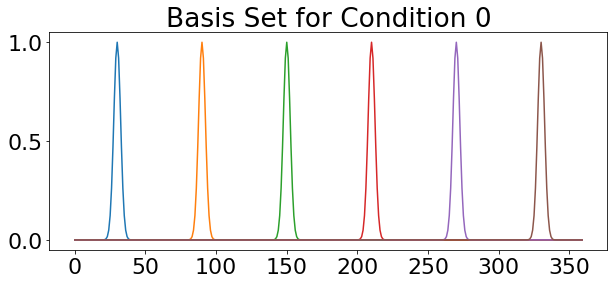

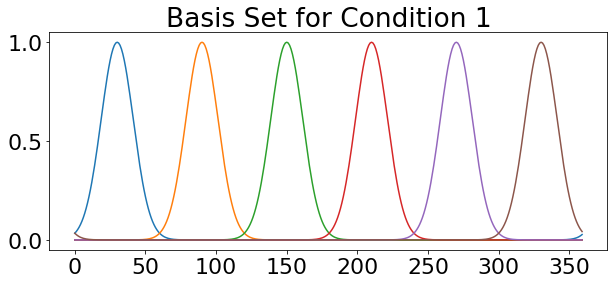

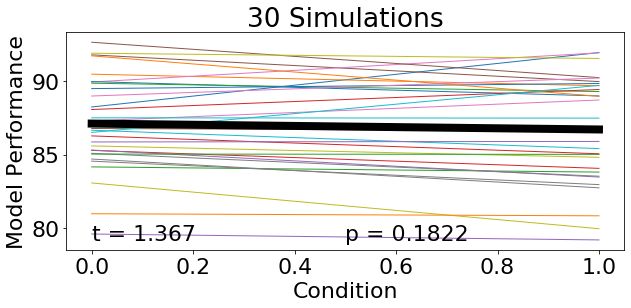

In [767]:
# compare possible basis sets
mae = np.full( (nsims, 2),np.nan )
for sims in np.arange(nsims):
    trial_by_vox, trial_features, trial_conds = sim_vox()
    for cond in np.arange(2):
        if cond == 0:
            basis_points = np.linspace(0,360-(360//nchannels),nchannels)+30
            channel_sd = np.ones(nchannels)*3
            chan_pow = np.ones(nchannels)
        else:
            basis_points = np.linspace(0,360-(360//nchannels),nchannels)+30
            channel_sd = np.ones(nchannels)*15
            chan_pow = np.ones(nchannels)
        mae[sims,cond] = np.mean(auto_recon(basis_points,trial_features,trial_by_vox,channel_sd,chan_pow))
    plt.plot(mae[sims,:], linewidth=1)
    
# correlation test
stats = sp.stats.ttest_rel(mae[:,0],mae[:,1])
tvalue = stats[0]
pvalue = stats[1]
    
plt.plot(np.mean(mae,axis=0), color='black', linewidth=8)
plt.title('30 Simulations')
plt.xlabel('Condition')
plt.ylabel('Model Performance')
plt.text(0,np.min(mae),"t = {}".format(np.round(tvalue,decimals=3)))
plt.text(0.5,np.min(mae),"p = {}".format(np.round(pvalue,decimals=4)))
plt.show()

## Medium-SD on-basis v. Large-SD on-basis (for medium vox SD)

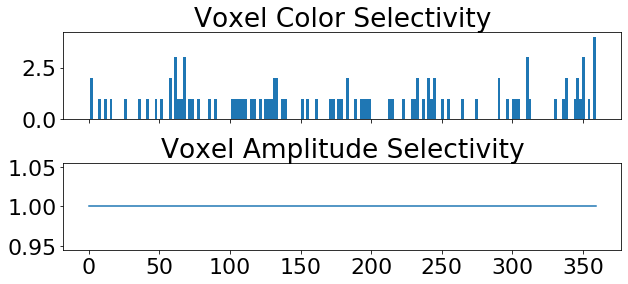

In [768]:
# Simulation parameters:
nsims = 30
ntrials = 300
nvoxels = 100
nneurons = 100
nchannels = 6
vox_gain_diff = 0
neuron_noise = 0
feature_space = np.linspace(0,359,360)

# Voxel (mu)
vox_mu_basis = np.linspace(0,360-(360//nchannels),nchannels)
vox_sd_mu = 20
vox_sd_sd = 15
y_mu = pm.NormalMixture.dist(w=np.ones(nchannels)/nchannels, 
                          mu=vox_mu_basis,
                          sigma=np.ones(nchannels)*vox_sd_sd)
vox_mu = within360(y_mu.random(size=nvoxels))

# Voxel (sd)
y_sd = pm.TruncatedNormal.dist(mu=vox_sd_mu, sd=vox_sd_sd, lower=0)
vox_by_neuron_sd = y_sd.random(size=(nvoxels*nneurons))

# Voxel (amp)
vox_amp = np.ones(360)

# Simulate voxels:
vox_by_neuron_mu = np.full( (nvoxels*nneurons), np.nan)
vox_by_neuron_amp = np.full( (nvoxels*nneurons), np.nan)
for vox in np.arange(nvoxels):
    n_mu = pm.Normal.dist(mu=vox_mu[vox],
                          sigma=vox_sd_sd)
    vox_by_neuron_mu[(vox*nneurons):((vox+1)*nneurons)] = within360(n_mu.random(size=nneurons))
    vox_by_neuron_amp[(vox*nneurons):((vox+1)*nneurons)] = vox_amp[int(vox_mu[vox])]

# setup cross-validation
n_splits = 2
kf = KFold(n_splits=n_splits, shuffle=False) 
X = np.linspace(0,ntrials-1,np.sum(ntrials)) 
kf.get_n_splits(X)

# Plot simulated voxel tunings:
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)    
fig.subplots_adjust(hspace=.5)
                
ax1.title.set_text('Voxel Color Selectivity')
ax1.hist(vox_mu, bins = 180)
    
ax2.plot(vox_amp)
ax2.title.set_text('Voxel Amplitude Selectivity')
plt.show()

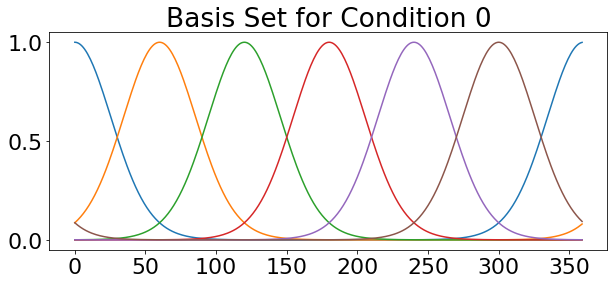

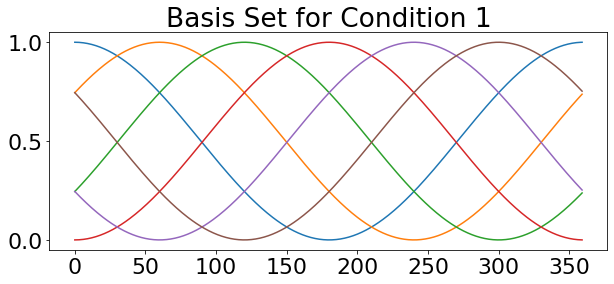

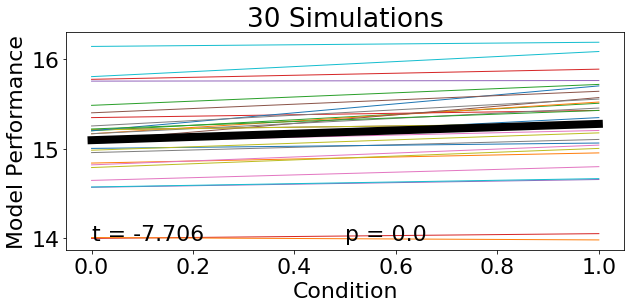

In [769]:
# compare possible basis sets
mae = np.full( (nsims, 2),np.nan )
for sims in np.arange(nsims):
    trial_by_vox, trial_features, trial_conds = sim_vox()
    for cond in np.arange(2):
        if cond == 0:
            basis_points = np.linspace(0,360-(360//nchannels),nchannels)
            channel_sd = np.ones(nchannels)*40
            chan_pow = np.ones(nchannels)
        else:
            basis_points = np.linspace(0,360-(360//nchannels),nchannels)
            channel_sd = np.ones(nchannels)*100
            chan_pow = np.ones(nchannels)
        mae[sims,cond] = np.mean(auto_recon(basis_points,trial_features,trial_by_vox,channel_sd,chan_pow))
    plt.plot(mae[sims,:], linewidth=1)
    
# correlation test
stats = sp.stats.ttest_rel(mae[:,0],mae[:,1])
tvalue = stats[0]
pvalue = stats[1]
    
plt.plot(np.mean(mae,axis=0), color='black', linewidth=8)
plt.title('30 Simulations')
plt.xlabel('Condition')
plt.ylabel('Model Performance')
plt.text(0,np.min(mae),"t = {}".format(np.round(tvalue,decimals=3)))
plt.text(0.5,np.min(mae),"p = {}".format(np.round(pvalue,decimals=4)))
plt.show()

## Small-SD on-basis v. Large-SD on-basis (for large-sd voxels)

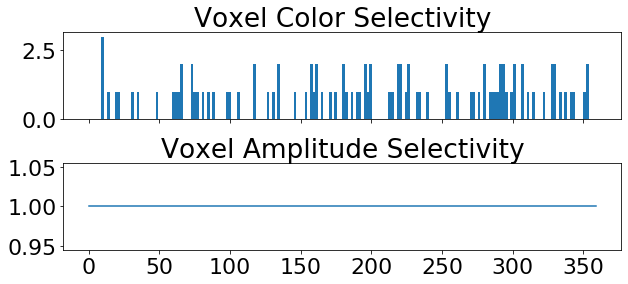

In [770]:
# Simulation parameters:
nsims = 30
ntrials = 300
nvoxels = 100
nneurons = 100
nchannels = 6
vox_gain_diff = 0
neuron_noise = 0
feature_space = np.linspace(0,359,360)

# Voxel (mu)
vox_mu_basis = np.linspace(0,360-(360//nchannels),nchannels)
vox_sd_mu = 40
vox_sd_sd = 30
y_mu = pm.NormalMixture.dist(w=np.ones(nchannels)/nchannels, 
                          mu=vox_mu_basis,
                          sigma=np.ones(nchannels)*vox_sd_sd)
vox_mu = within360(y_mu.random(size=nvoxels))

# Voxel (sd)
y_sd = pm.TruncatedNormal.dist(mu=vox_sd_mu, sd=vox_sd_sd, lower=0)
vox_by_neuron_sd = y_sd.random(size=(nvoxels*nneurons))

# Voxel (amp)
vox_amp = np.ones(360)

# Simulate voxels:
vox_by_neuron_mu = np.full( (nvoxels*nneurons), np.nan)
vox_by_neuron_amp = np.full( (nvoxels*nneurons), np.nan)
for vox in np.arange(nvoxels):
    n_mu = pm.Normal.dist(mu=vox_mu[vox],
                          sigma=vox_sd_sd)
    vox_by_neuron_mu[(vox*nneurons):((vox+1)*nneurons)] = within360(n_mu.random(size=nneurons))
    vox_by_neuron_amp[(vox*nneurons):((vox+1)*nneurons)] = vox_amp[int(vox_mu[vox])]
    
# setup cross-validation
n_splits = 2
kf = KFold(n_splits=n_splits, shuffle=False) 
X = np.linspace(0,ntrials-1,np.sum(ntrials)) 
kf.get_n_splits(X)

# Plot simulated voxel tunings:
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)    
fig.subplots_adjust(hspace=.5)
                
ax1.title.set_text('Voxel Color Selectivity')
ax1.hist(vox_mu, bins = 180)
    
ax2.plot(vox_amp)
ax2.title.set_text('Voxel Amplitude Selectivity')
plt.show()

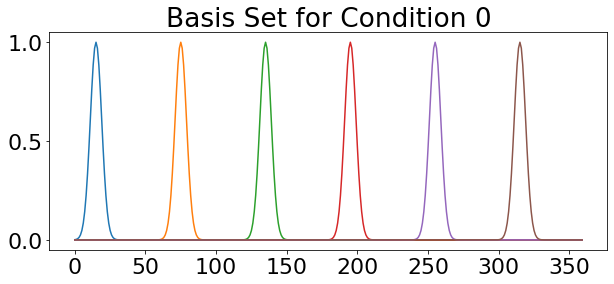

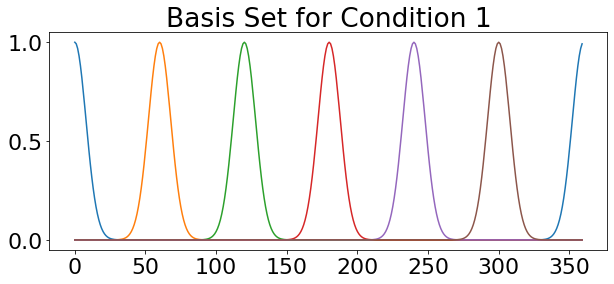

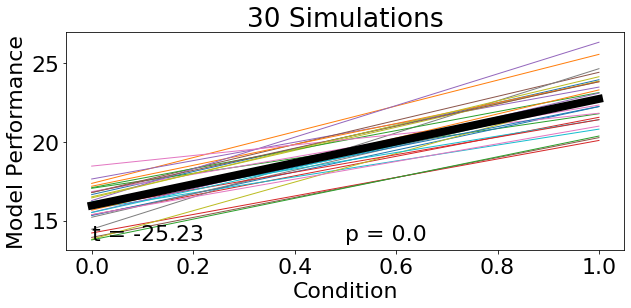

In [821]:
# compare possible basis sets
mae = np.full( (nsims, 2),np.nan )
for sims in np.arange(nsims):
    trial_by_vox, trial_features, trial_conds = sim_vox()
    for cond in np.arange(2):
        if cond == 0:
            basis_points = np.linspace(0,360-(360//nchannels),nchannels)+15
            channel_sd = np.ones(nchannels)*5
            chan_pow = np.ones(nchannels)
        else:
            basis_points = np.linspace(0,360-(360//nchannels),nchannels)
            channel_sd = np.ones(nchannels)*10
            chan_pow = np.ones(nchannels)
        mae[sims,cond] = np.mean(auto_recon(basis_points,trial_features,trial_by_vox,channel_sd,chan_pow))
    plt.plot(mae[sims,:], linewidth=1)
    
# correlation test
stats = sp.stats.ttest_rel(mae[:,0],mae[:,1])
tvalue = stats[0]
pvalue = stats[1]
    
plt.plot(np.mean(mae,axis=0), color='black', linewidth=8)
plt.title('30 Simulations')
plt.xlabel('Condition')
plt.ylabel('Model Performance')
plt.text(0,np.min(mae),"t = {}".format(np.round(tvalue,decimals=3)))
plt.text(0.5,np.min(mae),"p = {}".format(np.round(pvalue,decimals=4)))
plt.show()

# MCMC Fitting

In [225]:
class LogLike0(tt.Op):
    itypes = [tt.dvector] # expects a vector of parameter values when called
    otypes = [tt.dscalar] # outputs a single scalar value
    
    def __init__(self, function, basis_points, channel_sd, chan_pow, trial_features, trial_by_vox):

        # add inputs as class attributes
        self.likelihood = function
        self.basis_points = basis_points
        self.channel_sd = channel_sd
        self.chan_pow = chan_pow
        self.trial_features = trial_features
        self.trial_by_vox = trial_by_vox
        
        # initialise the gradient Op (below)
        self.logpgrad = LogLikeGrad(self.likelihood, self.basis_points, self.channel_sd, self.chan_pow,
                                   self.trial_features, self.trial_by_vox)

    def perform(self, node, inputs, outputs):
        # the method that is used when calling the Op
        theta, = inputs  # this will contain my variables

        # call the log-likelihood function
        logl = self.likelihood(theta, self.basis_points, self.channel_sd, self.chan_pow,
                              self.trial_features, self.trial_by_vox)

        outputs[0][0] = np.array(logl) # output the log-likelihood

class LogLike(tt.Op):
    itypes = [tt.dvector] # expects a vector of parameter values when called
    otypes = [tt.dscalar] # outputs a single scalar value
    
    def __init__(self, function, basis_points, channel_sd, chan_pow, trial_features, trial_by_vox):

        # add inputs as class attributes
        self.likelihood = function
        self.basis_points = basis_points
        self.channel_sd = channel_sd
        self.chan_pow = chan_pow
        self.trial_features = trial_features
        self.trial_by_vox = trial_by_vox
        
        # initialise the gradient Op (below)
        self.logpgrad = LogLikeGrad(self.likelihood, self.basis_points, self.channel_sd, self.chan_pow,
                                   self.trial_features, self.trial_by_vox)

    def perform(self, node, inputs, outputs):
        # the method that is used when calling the Op
        theta, = inputs  # this will contain my variables

        # call the log-likelihood function
        logl = self.likelihood(theta, self.basis_points, self.channel_sd, self.chan_pow,
                              self.trial_features, self.trial_by_vox)

        outputs[0][0] = np.array(logl) # output the log-likelihood
        
    def grad(self, inputs, g):
        # the method that calculates the gradients - it actually returns the
        # vector-Jacobian product - g[0] is a vector of parameter values
        theta, = inputs  # our parameters
        return [g[0]*self.logpgrad(theta)]
    
class LogLikeGrad(tt.Op):
    itypes = [tt.dvector]
    otypes = [tt.dvector]

    def __init__(self, function, basis_points, channel_sd, chan_pow, trial_features, trial_by_vox):

        # add inputs as class attributes
        self.likelihood = function
        self.basis_points = basis_points
        self.channel_sd = channel_sd
        self.chan_pow = chan_pow
        self.trial_features = trial_features
        self.trial_by_vox = trial_by_vox

    def perform(self, node, inputs, outputs):
        theta, = inputs

        # define version of likelihood function to pass to derivative function
        def lnlike(values):
            return self.likelihood(values, self.basis_points, self.channel_sd, self.chan_pow,
                                  self.trial_features, self.trial_by_vox)

        # calculate gradients
        grads = gradients(theta, lnlike)

        outputs[0][0] = grads

def gradients(vals, func, releps=1e-3, abseps=None, mineps=1e-9, reltol=1e-3,
              epsscale=0.5):
    """
    Calculate the partial derivatives of a function at a set of values. The
    derivatives are calculated using the central difference, using an iterative
    method to check that the values converge as step size decreases.

    Parameters
    ----------
    vals: array_like
        A set of values, that are passed to a function, at which to calculate
        the gradient of that function
    func:
        A function that takes in an array of values.
    releps: float, array_like, 1e-3
        The initial relative step size for calculating the derivative.
    abseps: float, array_like, None
        The initial absolute step size for calculating the derivative.
        This overrides `releps` if set.
        `releps` is set then that is used.
    mineps: float, 1e-9
        The minimum relative step size at which to stop iterations if no
        convergence is achieved.
    epsscale: float, 0.5
        The factor by which releps if scaled in each iteration.

    Returns
    -------
    grads: array_like
        An array of gradients for each non-fixed value.
    """

    grads = np.zeros(len(vals))

    # maximum number of times the gradient can change sign
    flipflopmax = 10.

    # set steps
    if abseps is None:
        if isinstance(releps, float):
            eps = np.abs(vals)*releps
            eps[eps == 0.] = releps  # if any values are zero set eps to releps
            teps = releps*np.ones(len(vals))
        elif isinstance(releps, (list, np.ndarray)):
            if len(releps) != len(vals):
                raise ValueError("Problem with input relative step sizes")
            eps = np.multiply(np.abs(vals), releps)
            eps[eps == 0.] = np.array(releps)[eps == 0.]
            teps = releps
        else:
            raise RuntimeError("Relative step sizes are not a recognised type!")
    else:
        if isinstance(abseps, float):
            eps = abseps*np.ones(len(vals))
        elif isinstance(abseps, (list, np.ndarray)):
            if len(abseps) != len(vals):
                raise ValueError("Problem with input absolute step sizes")
            eps = np.array(abseps)
        else:
            raise RuntimeError("Absolute step sizes are not a recognised type!")
        teps = eps

    # for each value in vals calculate the gradient
    count = 0
    for i in range(len(vals)):
        # initial parameter diffs
        leps = eps[i]
        cureps = teps[i]

        flipflop = 0

        # get central finite difference
        fvals = np.copy(vals)
        bvals = np.copy(vals)

        # central difference
        fvals[i] += 0.5*leps  # change forwards distance to half eps
        bvals[i] -= 0.5*leps  # change backwards distance to half eps
        cdiff = (func(fvals)-func(bvals))/leps

        while 1:
            fvals[i] -= 0.5*leps  # remove old step
            bvals[i] += 0.5*leps

            # change the difference by a factor of two
            cureps *= epsscale
            if cureps < mineps or flipflop > flipflopmax:
                # if no convergence set flat derivative (TODO: check if there is a better thing to do instead)
                warnings.warn("Derivative calculation did not converge: setting flat derivative.")
                grads[count] = 0.
                break
            leps *= epsscale

            # central difference
            fvals[i] += 0.5*leps  # change forwards distance to half eps
            bvals[i] -= 0.5*leps  # change backwards distance to half eps
            cdiffnew = (func(fvals)-func(bvals))/leps

            if cdiffnew == cdiff:
                grads[count] = cdiff
                break

            # check whether previous diff and current diff are the same within reltol
            rat = (cdiff/cdiffnew)
            if np.isfinite(rat) and rat > 0.:
                # gradient has not changed sign
                if np.abs(1.-rat) < reltol:
                    grads[count] = cdiffnew
                    break
                else:
                    cdiff = cdiffnew
                    continue
            else:
                cdiff = cdiffnew
                flipflop += 1
                continue

        count += 1

    return grads

In [229]:
# Simulation parameters:
sims=-1
ntrials = 1000
nvoxels = 100
nneurons = 100
nchannels = 6
vox_gain_diff = 0
neuron_noise = 0
feature_space = np.linspace(0,359,360)

true_sh = 13
true_sh_sd = .1
true_sd = 3
true_amp = 1

# Voxel (mu)
vox_mu_basis = np.linspace(0,360-(360//nchannels),nchannels)+true_sh
y_mu = pm.NormalMixture.dist(w=np.ones(nchannels)/nchannels, 
                          mu=vox_mu_basis,
                          sigma=np.ones(nchannels)*true_sh_sd)
vox_mu = within360(y_mu.random(size=nvoxels))

# Voxel (sd)
vox_sd_sd = .01
y_sd = pm.TruncatedNormal.dist(mu=true_sd, sd=vox_sd_sd, lower=0)
vox_by_neuron_sd = y_sd.random(size=(nvoxels*nneurons))

# Voxel (amp)
vox_amp = np.ones(360)

# Simulate voxels:
vox_by_neuron_mu = np.full( (nvoxels*nneurons), np.nan)
vox_by_neuron_amp = np.full( (nvoxels*nneurons), np.nan)
for vox in np.arange(nvoxels):
    n_mu = pm.Normal.dist(mu=vox_mu[vox],
                          sigma=.01)
    vox_by_neuron_mu[(vox*nneurons):((vox+1)*nneurons)] = within360(n_mu.random(size=nneurons))
    vox_by_neuron_amp[(vox*nneurons):((vox+1)*nneurons)] = vox_amp[int(vox_mu[vox])]

# setup cross-validation
n_splits = 2
kf = KFold(n_splits=n_splits, shuffle=False) 
X = np.linspace(0,ntrials-1,np.sum(ntrials)) 
kf.get_n_splits(X)

# run sim_vox
trial_by_vox, trial_features, trial_conds = sim_vox()

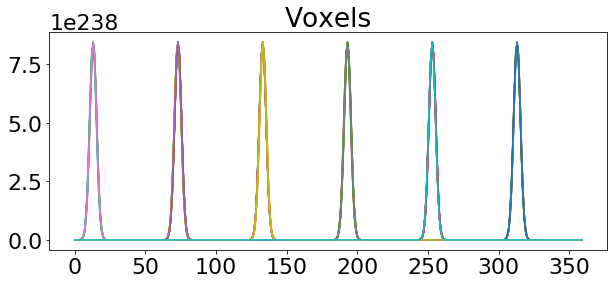

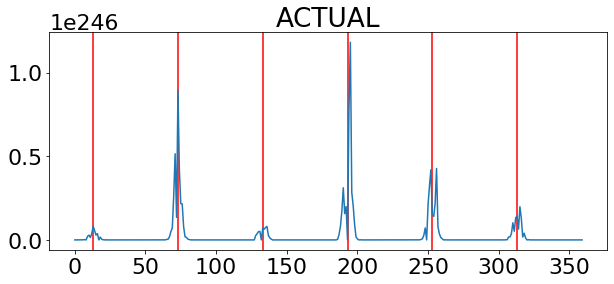

In [230]:
# Plot simulated voxel tunings:               
plt.title('Voxels')
for vox in np.arange(nvoxels):
    plt.plot(make_vox(np.linspace(0,359,360),vox_mu[vox],true_sd,vox_amp[vox]))    
plt.show()

# Plot actual voxel tunings:
cnt = np.zeros(360)
plt.title('ACTUAL')
for vox in np.arange(nvoxels):
    for trial in np.arange(ntrials):
        cnt[trial_features[trial]] = cnt[trial_features[trial]] + trial_by_vox[trial,vox]
for chan in np.arange(nchannels):
    plt.axvline(vox_mu_basis[chan],color='red')
plt.plot(cnt)
plt.show()

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS failed. Falling back to elementwise auto-assignment.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [sigma_p, sh_p]
>CompoundStep
>>Slice: [sh5]
>>Slice: [sh4]
>>Slice: [sh3]
>>Slice: [sh2]
>>Slice: [sh1]
>>Slice: [sh0]
Sampling 2 chains: 100%|██████████| 1500/1500 [18:02<00:00,  1.39draws/s] 
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5602109480086161, but should be close to 0.8. Try to increase the number of tuning steps.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7159314070353967, but should be close to 0.8. Try to increase the number of tuning steps.
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problem

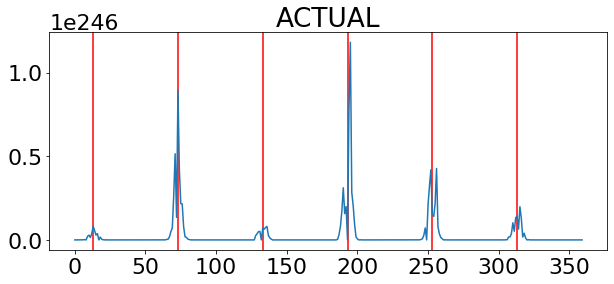

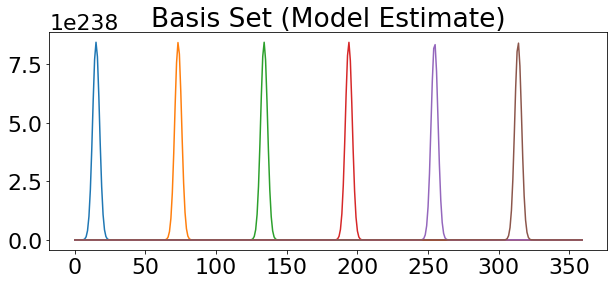

true sh: 13

[15.036 16.028]
[14.97556273 15.96323549]


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
sh0,15.046061,1.312860,0.110512,12.700937,17.841060,16.943750,1.084779
sh1,13.144675,1.154999,0.095166,10.466772,15.215291,26.174086,1.013820
sh2,13.944059,1.333440,0.085731,11.205980,16.456696,65.414292,1.011525
sh3,13.914757,1.035558,0.067252,11.758748,15.662948,69.209737,0.999820
sh4,14.616941,1.238833,0.095106,12.269889,16.687863,31.998278,1.030352
sh5,13.762893,1.159195,0.086208,11.863795,16.353549,39.070777,1.009322
sh_p,14.026265,0.872031,0.075440,12.304245,15.652812,28.100596,1.031894
sigma_p,1.102189,0.852717,0.076131,0.253952,2.790865,16.181272,1.057640


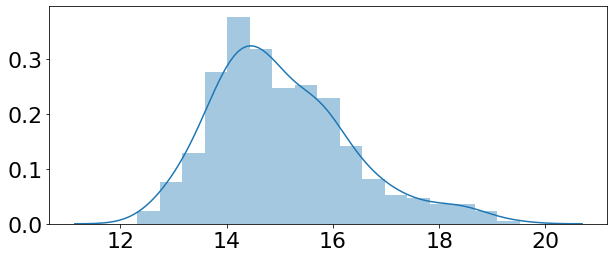

In [231]:
# setup parameter priors
basis_points = np.linspace(0,360-(360//nchannels),nchannels)
channel_sd = np.ones(nchannels)
chan_pow = np.ones(nchannels)

def pseudo_loglike(theta,basis_points,channel_sd,chan_pow,trial_features,trial_by_vox):
    sh = theta
    err = auto_recon(basis_points+sh,channel_sd*true_sd,chan_pow,trial_features,trial_by_vox)
    return -np.sum(err**2)

# create our Op
logl = LogLike0(pseudo_loglike,basis_points,channel_sd,chan_pow,trial_features,trial_by_vox)

with pm.Model():
    # Priors
    sh_p = pm.Uniform('sh_p', lower=0., upper=(360/nchannels)/2)
    sigma_p = pm.Exponential('sigma_p',1)
    
    for chan in np.arange(nchannels):
        locals()['sh{}'.format(chan)] = pm.Normal('sh{}'.format(chan),
                                                   mu=sh_p,sigma=sigma_p)
#     sh0 = pm.Normal('sh0',mu=sh_p,sigma=5)
    
    # convert to a tensor vector
    theta = tt.as_tensor_variable([sh0,sh1,sh2,sh3,sh4,sh5])
    
    # use a custom blackbox function (use a lamdba function to "call" the Op)
    pm.DensityDist('likelihood', lambda v: logl(v), observed={'v': theta})

    trace = pm.sample(200, tune=550, chains=2)
    
# Plot actual voxel tunings:
cnt = np.zeros(360)
plt.title('ACTUAL')
for vox in np.arange(nvoxels):
    for trial in np.arange(ntrials):
        cnt[trial_features[trial]] = cnt[trial_features[trial]] + trial_by_vox[trial,vox]
for chan in np.arange(nchannels):
    plt.axvline(vox_mu_basis[chan],color='red')
plt.plot(cnt)
plt.show()

for chan in np.arange(nchannels):
    basis_set[:,chan] = make_cos_basis_sd( feature_space, 
                                          (basis_points[chan]-180+np.mean(trace['sh{}'.format(chan)])),
                                          channel_sd[chan]*true_sd )
    plt.plot(basis_set[:,chan])
plt.title('Basis Set (Model Estimate)')
plt.show()

print('true sh: {}\n'.format(true_sh))
print(auto_recon(basis_points+true_sh,channel_sd*true_sd,chan_pow,trial_features,trial_by_vox))
print(auto_recon(basis_points+[np.mean(trace['sh0']),np.mean(trace['sh1']),np.mean(trace['sh2']),np.mean(trace['sh3']),np.mean(trace['sh4']),np.mean(trace['sh5'])],channel_sd*true_sd,chan_pow,trial_features,trial_by_vox))
    
sns.distplot(trace['sh0'], hist=True)
pm.summary(trace)


Only 250 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS failed. Falling back to elementwise auto-assignment.
Multiprocess sampling (2 chains in 2 jobs)
Slice: [sd]
Sampling 2 chains: 100%|██████████| 1700/1700 [02:10<00:00, 13.03draws/s]


true sd: 10



,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
sd,24.938747,8.705051,0.312912,10.717621,38.968571,601.437795,1.003628


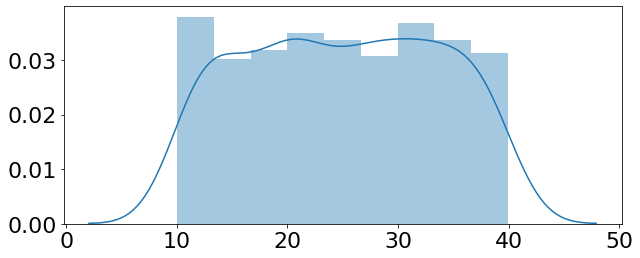

In [214]:
basis_points = np.linspace(0,360-(360//nchannels),nchannels)+true_sh
channel_sd = np.ones(nchannels)
chan_pow = np.ones(nchannels)

def pseudo_loglike(theta,basis_points,channel_sd,chan_pow,trial_features,trial_by_vox):
    sd = theta
    err = auto_recon(basis_points,channel_sd*sd,chan_pow,trial_features,trial_by_vox)
    return -np.sum(err**2)

# create our Op
logl = LogLike0(pseudo_loglike,basis_points,channel_sd,chan_pow,trial_features,trial_by_vox)

with pm.Model():
    # uniform prior
#     sh = pm.Uniform('sh', lower=0., upper=(360/nchannels)/2)
    sd = pm.Uniform('sd', lower=10., upper=40.)
#     amp = pm.Uniform('amp', lower=1., upper=10.)

    # convert to a tensor vector
    theta = tt.as_tensor_variable([sd])

    # use a custom blackbox function (use a lamdba function to "call" the Op)
    pm.DensityDist('likelihood', lambda v: logl(v), observed={'v': theta})
    
#     map_est = pm.find_MAP()

    trace = pm.sample(250, tune=600, chains=2)
#     , nuts_kwargs={'target_accept': 0.70})
    
# print(map_est['sh'])
# print('true sh: {}\n'.format(true_sh))
print('true sd: {}\n'.format(true_sd*2))
# print('true amp: {}\n'.format(true_amp))
# sns.distplot(trace['sh'], hist=True)
sns.distplot(trace['sd'], hist=True)
# sns.distplot(trace['amp'], hist=True)
pm.summary(trace)

Only 250 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS failed. Falling back to elementwise auto-assignment.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Slice: [sd]
>Slice: [sh]
Sampling 2 chains: 100%|██████████| 2500/2500 [04:40<00:00, 18.48draws/s]


true sh: 10

true sd: 10



,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
sh,12.240998,1.311464,0.076852,9.503652,14.121262,231.167713,1.002400
sd,11.735785,1.631455,0.089544,10.008999,15.155013,289.171026,0.998378


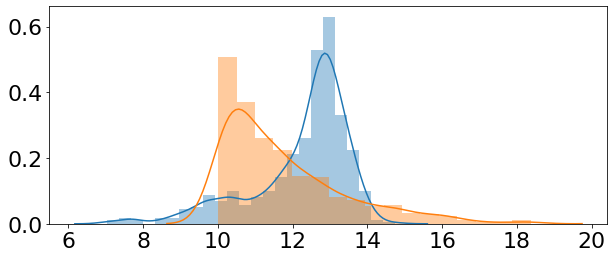

In [135]:
basis_points = np.linspace(0,360-(360//nchannels),nchannels)
channel_sd = np.ones(nchannels)
chan_pow = np.ones(nchannels)

def pseudo_loglike(theta,basis_points,channel_sd,chan_pow,trial_features,trial_by_vox):
    sh, sd = theta
    err = auto_recon(basis_points+sh,channel_sd*sd,chan_pow,trial_features,trial_by_vox)
    return -np.sum(err**2)

# create our Op
logl = LogLike0(pseudo_loglike,basis_points,channel_sd,chan_pow,trial_features,trial_by_vox)

with pm.Model():
    # uniform prior
    sh = pm.Uniform('sh', lower=0., upper=(360/nchannels)/2)
    sd = pm.Uniform('sd', lower=10., upper=40.)
#     amp = pm.Uniform('amp', lower=1., upper=10.)

    # convert to a tensor vector
    theta = tt.as_tensor_variable([sh,sd])

    # use a custom blackbox function (use a lamdba function to "call" the Op)
    pm.DensityDist('likelihood', lambda v: logl(v), observed={'v': theta})
    
#     map_est = pm.find_MAP()

    trace = pm.sample(250, tune=1000, chains=2)
#     , nuts_kwargs={'target_accept': 0.70})
    
# print(map_est['sh'])
print('true sh: {}\n'.format(true_sh))
print('true sd: {}\n'.format(true_sd*2))
# print('true amp: {}\n'.format(true_amp))
sns.distplot(trace['sh'], hist=True)
sns.distplot(trace['sd'], hist=True)
# sns.distplot(trace['amp'], hist=True)
pm.summary(trace)

# Compare With MVPA

Let's say we want to decode (e.g., classify) whether there is signal in our ROI that is different for conditions 1 and 2. Given all the voxels we have from half our dataset, can we decode above chance whether a trial was condition 1 or 2?

In [65]:
trn = trial_by_vox[:ntrials//2,:]
trn_cond = trial_conds[:ntrials//2]
trnf = trial_features[:ntrials//2]

tst = trial_by_vox[ntrials//2:,:]
tst_cond = trial_conds[ntrials//2:]
tstf = trial_features[ntrials//2:]

normalizer = StandardScaler()
trn = normalizer.fit_transform(trn)
tst = normalizer.fit_transform(tst)

In [66]:
model = LinearSVC(C=1)

model.fit(trn, trn_cond)

score = model.score(tst, tst_cond)
print('Accuracy = {}'.format(score))
print('Chance = 0.50')

Accuracy = 0.9682539682539683
Chance = 0.50


What if we want to decode the actual color?

MAE: 79.46825396825396


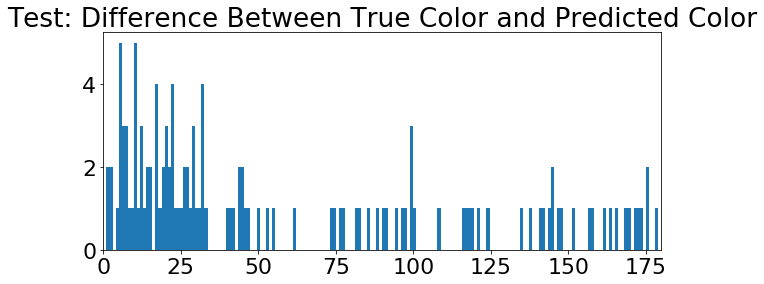

In [68]:
model.fit(trn, trnf)

predictions = model.predict(tst)

plt.hist(within180(predictions - tstf), bins=180, label="")
plt.xlim(xmin=0, xmax = 180)
plt.title("Test: Difference Between True Color and Predicted Color")

tst_mae = mean_absolute_error(within180(tstf), within180(predictions))
print("MAE: {}".format(tst_mae))

In [ ]:
with pm.Model() as hierarchical_model:
    # Priors (p stands for prior, 
    # I leave out the letter for the group-level parameters we can later make inferences on)
    target_mu = pm.TruncatedNormal('target_mu', mu=0, sd=.5, lower=np.deg2rad(-15), upper=np.deg2rad(15))
    target_mu_sd = pm.Gamma('target_mu_sd', alpha=2, beta=10)
    
    p_memA = pm.Exponential('p_memA', .1)
    p_memB = pm.Exponential('p_memB', .1)
    
    p_tarA = pm.Exponential('p_tarA', .1)
    p_tarB = pm.Exponential('p_tarB', .1)
    
    p_target_shape = pm.Exponential('p_target_shape', .1)
    p_target_rate = pm.Exponential('p_target_rate', 1)
    p_swap_shape = pm.Exponential('p_swap_shape', .1)
    p_swap_rate = pm.Exponential('p_swap_rate', 1)
    
    # Deterministic transformations   
    mem = pm.Deterministic('mem',p_memA/(p_memA + p_memB)) # 1-mem = proportion of random guessing
    target = pm.Deterministic('target',mem * (p_tarA/(p_tarA + p_tarB)))
    swap = pm.Deterministic('swap',mem * (1-(p_tarA/(p_tarA + p_tarB)))) 
    target_k = pm.Bound(pm.Gamma, lower=.609, upper=33.33)('target_k', alpha=p_target_shape, beta=p_target_rate)
    swap_k = pm.Bound(pm.Gamma, lower=.609, upper=33.33)('swap_k', alpha=p_swap_shape, beta=p_swap_rate)

    # Individual subject level (i stands for individual-level parameter)
    i_target_mu_tilde = pm.Normal('i_target_mu_tilde', mu=0, sd=1, shape=nsubj) #non-centered reparameterization
    i_target_mu = pm.Deterministic('i_target_mu', target_mu + i_target_mu_tilde * target_mu_sd)
    i_mem = pm.Beta('i_mem', alpha=p_memA, beta=p_memB, shape=nsubj)
    i_tar = pm.Beta('i_tar', alpha=p_tarA, beta=p_tarB, shape=nsubj) # tar refers to conditional probability of target
    i_target_k = pm.Bound(pm.Gamma, lower=.609, upper=33.33)('i_target_k', alpha=p_target_shape, beta=p_target_rate, shape=nsubj)
    i_swap_k = pm.Bound(pm.Gamma, lower=.609, upper=33.33)('i_swap_k', alpha=p_swap_shape, beta=p_swap_rate, shape=nsubj)
    
    # Trial-level
    dists = [
        pm.Uniform.dist(lower=np.full(ntrials,-np.pi), upper=np.full(ntrials,np.pi)), #random guessing
        pm.VonMises.dist(mu=i_target_mu[id], kappa=i_target_k[id]), #target with bias
        pm.VonMises.dist(mu=swap_loc, kappa=i_swap_k[id]), #swap
    ]
    
    w = tt.stack([1 - i_mem[id], i_mem[id] * i_tar[id], i_mem[id] * (1-i_tar[id])])
    
    y = pm.Mixture('y', w.T, dists, observed=color_err)

# testing gradients

In [98]:
class LogLike(tt.Op):

    """
    Specify what type of object will be passed and returned to the Op when it is
    called. In our case we will be passing it a vector of values (the parameters
    that define our model) and returning a single "scalar" value (the
    log-likelihood)
    """
    itypes = [tt.dvector] # expects a vector of parameter values when called
    otypes = [tt.dscalar] # outputs a single scalar value (the log likelihood)

    def __init__(self, loglike, data, x, sigma):
        """
        Initialise the Op with various things that our log-likelihood function
        requires. Below are the things that are needed in this particular
        example.

        Parameters
        ----------
        loglike:
            The log-likelihood (or whatever) function we've defined
        data:
            The "observed" data that our log-likelihood function takes in
        x:
            The dependent variable (aka 'x') that our model requires
        sigma:
            The noise standard deviation that our function requires.
        """

        # add inputs as class attributes
        self.likelihood = loglike
        self.data = data
        self.x = x
        self.sigma = sigma

    def perform(self, node, inputs, outputs):
        # the method that is used when calling the Op
        theta, = inputs  # this will contain my variables

        # call the log-likelihood function
        logl = self.likelihood(theta, self.x, self.data, self.sigma)

        outputs[0][0] = np.array(logl) # output the log-likelihood

In [126]:
def my_model(theta, x):
    m, c = theta
    return m*x + c

def my_loglike(theta, x, data, sigma):
    model = my_model(theta, x)
    return -(0.5/sigma**2)*np.sum((data - model)**2)

In [129]:
# set up our data
N = 10  # number of data points
sigma = 1.  # standard deviation of noise
x = np.linspace(0., 9., N)

mtrue = 0.4  # true gradient
ctrue = 3.   # true y-intercept

truemodel = my_model([mtrue, ctrue], x)

# make data
np.random.seed(716742)  # set random seed, so the data is reproducible each time
data = sigma*np.random.randn(N) + truemodel

In [130]:
# create our Op
logl = LogLike(my_loglike, data, x, sigma)

# use PyMC3 to sampler from log-likelihood
with pm.Model():
    # uniform priors on m and c
    m = pm.Uniform('m', lower=-10., upper=10.)
    c = pm.Uniform('c', lower=-10., upper=10.)

    # convert m and c to a tensor vector
    theta = tt.as_tensor_variable([m, c])

    # use a DensityDist (use a lamdba function to "call" the Op)
    pm.DensityDist('likelihood', lambda v: logl(v), observed={'v': theta})

    trace = pm.sample(3000,tune=1000,discard_tuned_samples=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS failed. Falling back to elementwise auto-assignment.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Slice: [c]
>Slice: [m]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:11<00:00, 697.79draws/s]
The number of effective samples is smaller than 25% for some parameters.


In [131]:
display(pm.summary(trace))
print(mtrue)
print(ctrue)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
m,0.388004,0.074880,0.002281,0.242144,0.532786,1021.149703,1.001330
c,2.918475,0.401593,0.012390,2.118112,3.681680,1037.491738,1.001011


0.4
3.0


In [9]:
# define a theano Op for our likelihood function
class LogLikeWithGrad(tt.Op):

    itypes = [tt.dvector] # expects a vector of parameter values when called
    otypes = [tt.dscalar] # outputs a single scalar value (the log likelihood)

    def __init__(self, loglike, data, x, sigma):
        """
        Initialise with various things that the function requires. Below
        are the things that are needed in this particular example.

        Parameters
        ----------
        loglike:
            The log-likelihood (or whatever) function we've defined
        data:
            The "observed" data that our log-likelihood function takes in
        x:
            The dependent variable (aka 'x') that our model requires
        sigma:
            The noise standard deviation that out function requires.
        """

        # add inputs as class attributes
        self.likelihood = loglike
        self.data = data
        self.x = x
        self.sigma = sigma

        # initialise the gradient Op (below)
        self.logpgrad = LogLikeGrad(self.likelihood, self.data, self.x, self.sigma)

    def perform(self, node, inputs, outputs):
        # the method that is used when calling the Op
        theta, = inputs  # this will contain my variables

        # call the log-likelihood function
        logl = self.likelihood(theta, self.x, self.data, self.sigma)

        outputs[0][0] = np.array(logl) # output the log-likelihood

    def grad(self, inputs, g):
        # the method that calculates the gradients - it actually returns the
        # vector-Jacobian product - g[0] is a vector of parameter values
        theta, = inputs  # our parameters
        return [g[0]*self.logpgrad(theta)]

class LogLikeGrad(tt.Op):

    """
    This Op will be called with a vector of values and also return a vector of
    values - the gradients in each dimension.
    """
    itypes = [tt.dvector]
    otypes = [tt.dvector]

    def __init__(self, loglike, data, x, sigma):
        """
        Initialise with various things that the function requires. Below
        are the things that are needed in this particular example.

        Parameters
        ----------
        loglike:
            The log-likelihood (or whatever) function we've defined
        data:
            The "observed" data that our log-likelihood function takes in
        x:
            The dependent variable (aka 'x') that our model requires
        sigma:
            The noise standard deviation that out function requires.
        """

        # add inputs as class attributes
        self.likelihood = loglike
        self.data = data
        self.x = x
        self.sigma = sigma

    def perform(self, node, inputs, outputs):
        theta, = inputs

        # define version of likelihood function to pass to derivative function
        def lnlike(values):
            return self.likelihood(values, self.x, self.data, self.sigma)

        # calculate gradients
        grads = gradients(theta, lnlike)

        outputs[0][0] = grads

In [1190]:
# create our Op
logl = LogLikeWithGrad(my_loglike, data, x, sigma)

# use PyMC3 to sampler from log-likelihood
with pm.Model():
    # uniform priors on m and c
    m = pm.Uniform('m', lower=-10., upper=10.)
    c = pm.Uniform('c', lower=-10., upper=10.)

    # convert m and c to a tensor vector
    theta = tt.as_tensor_variable([m, c])

    # use a DensityDist (use a lamdba function to "call" the Op)
    pm.DensityDist('likelihood', lambda v: logl(v), observed={'v': theta})

    trace = pm.sample(3000,tune=1000,discard_tuned_samples=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [c, m]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:17<00:00, 457.01draws/s]
The number of effective samples is smaller than 25% for some parameters.


In [1191]:
display(pm.summary(trace))
print(mtrue)
print(ctrue)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
m,0.391956,0.11177,0.002823,0.176704,0.618682,1578.978482,1.002510
c,2.899666,0.59664,0.014997,1.765798,4.109932,1493.948626,1.003152


0.4
3.0


In [22]:
# test the gradient Op by direct call
theano.config.compute_test_value = "ignore"
theano.config.exception_verbosity = "high"

var = tt.dvector()
test_grad_op = LogLikeGrad(my_loglike, data, x, sigma)
test_grad_op_func = theano.function([var], test_grad_op(var))

print(mtrue,ctrue,'\n')
print(test_grad_op_func([mtrue, ctrue]))
print('\n')
print(test_grad_op_func([mtrue+.001, ctrue]))
print(test_grad_op_func([mtrue+.05, ctrue]))
print(test_grad_op_func([mtrue+.1, ctrue]))
print('\n')
print(test_grad_op_func([mtrue, ctrue+.1]))
print(test_grad_op_func([mtrue, ctrue+.4]))
print(test_grad_op_func([mtrue, ctrue+1]))

0.4 3.0 

[-7.17656625 -1.39486358]


[-7.46156625 -1.43986358]
[-21.42656625  -3.64486358]
[-35.67656625  -5.89486358]


[-11.67656625  -2.39486358]
[-25.17656625  -5.39486358]
[-52.17656625 -11.39486358]


In [297]:
def pseudo_loglike(theta,basis_points,channel_sd,chan_pow,trial_features,trial_by_vox):
    sh = theta
#     sh, sd = theta
    maes = auto_recon(basis_points+sh,channel_sd*true_sd,chan_pow,trial_features,trial_by_vox)
    return -np.sum(maes**3)

# create our Op
logl = LogLike(pseudo_loglike,basis_points,channel_sd,chan_pow,trial_features,trial_by_vox)

# test the gradient Op by direct call
theano.config.compute_test_value = "ignore"
theano.config.exception_verbosity = "high"

var = tt.dvector()
test_grad_op = LogLikeGrad(pseudo_loglike,basis_points,channel_sd,chan_pow,trial_features,trial_by_vox)
test_grad_op_func = theano.function([var], test_grad_op(var))

print(true_sh,'\n')
print(test_grad_op_func([true_sh]))
print(test_grad_op_func([15]))
print(test_grad_op_func([25]))

20 

[-50.59712737]
[317.59510246]
[-92.7854558]


In [ ]:
def pseudo_loglike(theta,basis_points,channel_sd,chan_pow,trial_features,trial_by_vox):
    sd = theta
#     sh, sd = theta
    maes = auto_recon(basis_points+20,channel_sd*sd,chan_pow,trial_features,trial_by_vox)
    return -np.sum(maes**3)

# create our Op
logl = LogLike(pseudo_loglike,basis_points,channel_sd,chan_pow,trial_features,trial_by_vox)

# test the gradient Op by direct call
theano.config.compute_test_value = "ignore"
theano.config.exception_verbosity = "high"

var = tt.dvector()
test_grad_op = LogLikeGrad(pseudo_loglike,basis_points,channel_sd,chan_pow,trial_features,trial_by_vox)
test_grad_op_func = theano.function([var], test_grad_op(var))

print(true_sd,'\n')
print(test_grad_op_func([true_sd]))
print(test_grad_op_func([20]))
print(test_grad_op_func([26]))

In [14]:
# test the gradient Op by direct call
theano.config.compute_test_value = "ignore"
theano.config.exception_verbosity = "high"

var = tt.dvector()
test_grad_op = LogLikeGrad(my_loglike, data, x, sigma)
test_grad_op_func = theano.function([var], test_grad_op(var))
grad_vals = test_grad_op_func([mtrue, ctrue])

print('Gradient returned by "LogLikeGrad": {}'.format(grad_vals))

# test the gradient called through LogLikeWithGrad
test_gradded_op = LogLikeWithGrad(my_loglike, data, x, sigma)
test_gradded_op_grad = tt.grad(test_gradded_op(var), var)
test_gradded_op_grad_func = theano.function([var], test_gradded_op_grad)
grad_vals_2 = test_gradded_op_grad_func([mtrue, ctrue])

print('Gradient returned by "LogLikeWithGrad": {}'.format(grad_vals_2))

# test the gradient that PyMC3 uses for the Normal log likelihood
test_model = pm.Model()
with test_model:
    m = pm.Uniform('m', lower=-10., upper=10.)
    c = pm.Uniform('c', lower=-10., upper=10.)

    pm.Normal('likelihood', mu=(m*x + c), sigma=sigma, observed=data)

    gradfunc = test_model.logp_dlogp_function([m, c], dtype=None)
    gradfunc.set_extra_values({'m_interval__': mtrue, 'c_interval__': ctrue})
    grad_vals_pymc3 = gradfunc(np.array([mtrue, ctrue]))[1]  # get dlogp values

print('Gradient returned by PyMC3 "Normal" distribution: {}'.format(grad_vals_pymc3))

Gradient returned by "LogLike": -1.3249385728387384
Gradient returned by "LogLikeWithGrad": [-7.17656625 -1.39486358]
Gradient returned by PyMC3 "Normal" distribution: [-7.17656625 -1.39486358]
